In [126]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from read_roi import read_roi_zip
from collections import OrderedDict, Counter
import math
import PIL
from PIL import Image
from PIL.TiffTags import TAGS
import tkinter as tk
from tkinter import filedialog
import seaborn as sns

# Read, format and save raw data from ROIs #

In [ ]:
askdirectory = filedialog.askdirectory() # show an "Open" dialog box and return the path to the selected file
path = Path(askdirectory)
path

WindowsPath('C:/Users/Brouhard Lab/Data/Images/2023-01-02_DCX-EB_dynamics/2023-01-02_dynamics_Ch4-tub06uM_DCX-none-00nM_EB20nM')

In [150]:
tubulin = '[Tubulin] ' r'$(\mu M)$'
tub = 'tub'

DCXconc = '[DCX] ' r'$(n M)$'
DCX = 'DCX'
Type = 'DCX Type'


EBconc = '[EB] ' r'$(n M)$'
EB = 'EB'

investigator = 'Brandi'

In [151]:
dateloc = str(path).find("202")
date = str(path)[dateloc : dateloc+10]

folders = [x for x in path.iterdir() if x.is_dir()]
folders = [i for i in folders if (str(i)[-7:] == 'finalDS') == True]

ch = []
conc_tub = []
conc_DCX = []
conc_EB = []
DCX_type = []

for i in folders:
    CHloc = str(i).rfind("Ch")
    tubloc = str(i).rfind(tub)
    DCXloc = str(i).rfind(DCX)
    dcxtype = str(i).find("type")
    EBloc = str(i).rfind(EB)
    ch = ch + [str(i)[CHloc+2:CHloc+3]]
    conc_tub = conc_tub + [(str(i)[tubloc+3:tubloc+5])]
    conc_DCX = conc_DCX + [(str(i)[DCXloc+9:DCXloc+11])]
    conc_EB = conc_EB + [(str(i)[EBloc+2:EBloc+4])]
    DCX_type = DCX_type + [(str(i)[DCXloc+4:DCXloc+8])]

date,ch, conc_tub, conc_DCX, DCX_type, conc_EB


('2023-01-02', ['4'], ['06'], ['00'], ['none'], ['20'])

In [152]:
tub_conc =  [float(i) for i in conc_tub]
DCX_conc =  [float(i) for i in conc_DCX]
EB_conc = [float(i) for i in conc_EB]
frame_analyzer = pd.read_csv(path/'frame_rates_avg.csv',sep=',')
pixel =  0.107 #T2 0.107 #T1 0.0633
folders

[WindowsPath('C:/Users/Brouhard Lab/Data/Images/2023-01-02_DCX-EB_dynamics/2023-01-02_dynamics_Ch4-tub06uM_DCX-none-00nM_EB20nM/2023-01-02_dynamics_Ch4-tub06uM_DCX-none-00nM_EB20nM_finalDS')]

In [153]:
#frame_analyzer = frame_analyzer.iloc[[1,3]].reset_index()
frame_analyzer

,Directory,Mean,SD,Frames,Outliers,MeanWOutliers,SDWOutliers
0,C:\Users\Brouhard Lab\Data\Images\2023-01-02_D...,3.07,0.06,450,0,3.07,0.06


In [154]:
def open_roi_poly(k,name):
    roi_path = folders[k]/(name)

    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','x3','y1','y2','y3'])
    
    for key in roi_data:
        roi_df1 = pd.DataFrame({'Track ID': [roi_data[key]['name']],'x1': [roi_data[key]['x'][0]],'x2': [roi_data[key]['x'][1]],'x3': [roi_data[key]['x'][2]],'y1': [roi_data[key]['y'][0]],'y2': [roi_data[key]['y'][1]],'y3': [roi_data[key]['y'][2]]})
        roi_df = pd.concat([roi_df,roi_df1])
    
    roi_df = roi_df.reset_index(drop = True)
    return roi_df

def open_roi_line(k,name):
    roi_path = folders[k]/(name)
    roi_data = read_roi_zip(roi_path)
    roi_df = pd.DataFrame(columns=['Track ID','x1','x2','y1','y2'])
    
    for key in roi_data:
        roi_df1 = pd.DataFrame({'Track ID': [roi_data[key]['name']],'x1': [roi_data[key]['x1']],'x2': [roi_data[key]['x2']],'y1': [roi_data[key]['y1']],'y2': [roi_data[key]['y2']]})
        roi_df = pd.concat([roi_df,roi_df1])
        
    roi_df = roi_df.reset_index(drop = True)
    return roi_df


In [155]:
open_roi_poly(0,'kymoslopes.zip')

,Track ID,x1,x2,x3,y1,y2,y3
0,0076-0073,47,100,45,27,118,125
1,0069-0065,49,80,49,41,92,96
2,0243-0035,25,46,24,220,262,265
3,0055-0033,24,41,25,34,72,75
4,0407-0039,25,52,27,380,429,434
...,...,...,...,...,...,...,...
59,0159-0046,37,55,37,142,174,175
60,0188-0039,36,43,35,180,196,196
61,0229-0042,35,50,33,210,245,248
62,0283-0051,36,65,36,250,312,316


In [156]:
roi_path = folders[0]/('start.zip')
roi_data = read_roi_zip(roi_path)
roi_data

OrderedDict([('0008-0041',
              {'type': 'polyline',
               'x': [34.16666793823242, 41.16666793823242, 47.16666793823242],
               'y': [15.833333015441895,
                7.166666030883789,
                0.16666603088378906],
               'n': 3,
               'width': 0,
               'name': '0008-0041',
               'position': 0}),
             ('0008-0063',
              {'type': 'polyline',
               'x': [58.16666793823242, 63.833335876464844, 68.16667175292969],
               'y': [16.83333396911621,
                6.500000953674316,
                -0.16666603088378906],
               'n': 3,
               'width': 0,
               'name': '0008-0063',
               'position': 0})])

In [157]:
Length = 'Length ' r'$(\mu m)$'
Lifetime = 'Lifetime ' r'$(min)$'
GrowthRate = 'Growth Rate ' r'$(\mu m / min)$'
TimeToNucleate = 'Time to Nucleate ' r'$(min)$'
ShrinkageLength = 'Shrink Length ' r'$(\mu m)$'
ShrinkageLifetime = 'Shrink Lifetime ' r'$(min)$'
ShrinkageRate = 'Shrink Rate ' r'$(\mu m / min)$'
poly_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate)
line_parameter_names = (Length,Lifetime,GrowthRate,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate)

In [158]:
def poly_dynamics(k):
        
    data = open_roi_poly(k,'kymoslopes.zip')
    supp = open_roi_poly(k,'start.zip')
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data)
    pre_df ={'Date': np.full((n), date), 'Investigator': np.full((n), investigator),
              'Ch': np.full((n), ch[k]),tubulin: np.full((n), tub_conc[k]),DCXconc: np.full((n), DCX_conc[k]),EBconc: np.full((n), EB_conc[k])}
    df = pd.DataFrame(pre_df) 
    
    df[Length] = abs((data['x2']-data['x1'])*pixel)
    data[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x[Lifetime] != 0 else np.NaN, axis=1)
    
    df[GrowthRate] = df[Length]/df[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NAN )
    
    df[TimeToNucleate] = (data['y1']-start)*spf/60
    
    df[ShrinkageLength] = abs((data['x3']-data['x2'])*pixel)
    df[ShrinkageLifetime] = abs((data['y3']-data['y2'])*spf/60)
    df[ShrinkageLifetime] = df[ShrinkageLifetime].apply(lambda x: np.NAN if x == 0 else x)
    df[ShrinkageRate] = df[ShrinkageLength]/df[ShrinkageLifetime]
    
    df.loc[pd.isnull(df[GrowthRate]), 
           [Length,Lifetime,TimeToNucleate,ShrinkageLength,ShrinkageLifetime,ShrinkageRate]] = np.NaN
    
    df['Rescues'] = df[[Length,ShrinkageLength]].apply(lambda x: True if abs(x[Length]-x[ShrinkageLength]) > pixel*5 else False, axis=1)
    
    df['DCX Type'] = DCX_type[k]
    
    return df

def line_dynamics(k):
        
    data = open_roi_line(k,'kymoslope_line.zip')
    supp = open_roi_line(k,'start_line.zip')
    
    
    spf = frame_analyzer['Mean'][k];
    frames = frame_analyzer['Frames'][k]-2
    
    suppn = len(supp)
    start = sum(abs(supp['y2']-supp['y1']))/suppn;
    
    n = len(data)
    pre_df = {'Date': np.full((n), date),'Ch': np.full((n), ch[k]),'Concentration ' r'$(\mu M)$': np.full((n), tub_conc[k])}
    df = pd.DataFrame(pre_df) 
    
    
    df[Length] = abs((data['x2']-data['x1'])*pixel)
    df[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    
    df[GrowthRate] = df[Length]/df[Lifetime]
    df[GrowthRate] = df[GrowthRate].apply(lambda x: x if x <= 5 else np.NaN )
    
    data[Lifetime] = abs((data['y2']-data['y1'])*spf/60)
    df[Lifetime] = data[[Lifetime,'y2']].apply(lambda x: x[Lifetime] if x['y2'] < frames else np.NaN, axis=1)
    
    df[Length] = df[GrowthRate]*df[Lifetime]
    
    df.loc[pd.isnull(df[GrowthRate]), [Length,
        Lifetime]] = np.NaN
    
    df = df[['Date','Ch','Concentration ' r'$(\mu M)$',Length,
             Lifetime,GrowthRate]]

    
    return df


In [159]:
path.parents[0],path

(WindowsPath('C:/Users/Brouhard Lab/Data/Images/2023-01-02_DCX-EB_dynamics'),
 WindowsPath('C:/Users/Brouhard Lab/Data/Images/2023-01-02_DCX-EB_dynamics/2023-01-02_dynamics_Ch4-tub06uM_DCX-none-00nM_EB20nM'))

In [160]:
newdirectory = str(path.parents[0])+'//Data_Sheets'
newmydir = Path(newdirectory)
newmydir.mkdir(exist_ok=True)

In [161]:
df = poly_dynamics(0)
for i in range(1,len(ch)):
    df0 = poly_dynamics(i)
    df = df.append(df0, ignore_index=True)

df.to_csv(path/(investigator+'_'+date +'.csv'), encoding='utf-8', index=False)
df.to_csv(newmydir/(investigator+'_'+date+'.csv'), encoding='utf-8', index=False)
df

,Date,Investigator,Ch,[Tubulin] $(\mu M)$,[DCX] $(n M)$,[EB] $(n M)$,Length $(\mu m)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Time to Nucleate $(min)$,Shrink Length $(\mu m)$,Shrink Lifetime $(min)$,Shrink Rate $(\mu m / min)$,Rescues,DCX Type
0,2023-01-02,Brandi,4,6.0,0.0,20.0,5.671,4.656167,1.217955,0.895417,5.885,0.358167,16.430898,False,none
1,2023-01-02,Brandi,4,6.0,0.0,20.0,3.317,2.609500,1.271125,1.61175,3.317,0.204667,16.20684,False,none
2,2023-01-02,Brandi,4,6.0,0.0,20.0,2.247,2.149000,1.045603,10.770583,2.354,0.153500,15.335505,False,none
3,2023-01-02,Brandi,4,6.0,0.0,20.0,1.819,1.944333,0.935539,1.253583,1.712,0.153500,11.153094,False,none
4,2023-01-02,Brandi,4,6.0,0.0,20.0,2.889,2.507167,1.152297,18.95725,2.675,0.255833,10.456026,False,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2023-01-02,Brandi,4,6.0,0.0,20.0,1.926,1.637333,1.176303,6.779583,1.926,0.051167,37.641694,False,none
60,2023-01-02,Brandi,4,6.0,0.0,20.0,0.749,0.818667,0.914902,8.723917,0.856,NaN,NaN,False,none
61,2023-01-02,Brandi,4,6.0,0.0,20.0,1.605,1.790833,0.896231,10.258917,1.819,0.153500,11.850163,False,none
62,2023-01-02,Brandi,4,6.0,0.0,20.0,3.103,3.172333,0.978144,12.305583,3.103,0.204667,15.161238,False,none


In [162]:
dfmean = df.groupby('Ch').mean()
dfmean.to_csv(path/(date+'_0_mean.csv'), encoding='utf-8', index=False)
dfmean

,[Tubulin] $(\mu M)$,[DCX] $(n M)$,[EB] $(n M)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Shrink Lifetime $(min)$,Rescues
Ch,,,,,,,
4,6.0,0.0,20.0,2.152331,1.184447,0.147908,0.03125


In [163]:
dfstd = df.groupby('Ch').std()
dfstd.to_csv(path/(date+'_0_std.csv'), encoding='utf-8', index=False)
dfstd

,[Tubulin] $(\mu M)$,[DCX] $(n M)$,[EB] $(n M)$,Lifetime $(min)$,Growth Rate $(\mu m / min)$,Shrink Lifetime $(min)$,Rescues
Ch,,,,,,,
4,0.0,0.0,0.0,1.33544,0.192846,0.093817,0.175368


# Preliminary plot Histograms #

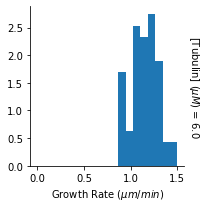

In [164]:
g = sns.FacetGrid(df, row=tubulin, margin_titles=True)
bins = np.linspace(0, 1.5, 20)
g.map(plt.hist, GrowthRate, bins=bins, density=True)
plt.savefig(path/('Growth_Rate'+'_'+date+'.jpg'),bbox_inches='tight')

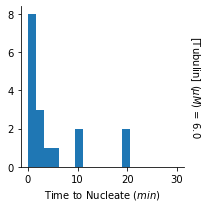

In [149]:
g = sns.FacetGrid(df, row=tubulin, margin_titles=True)
bins = np.linspace(0, 30, 20)
g.map(plt.hist, TimeToNucleate, bins=bins)
plt.savefig(path/('Time_to_Nucleate'+'_'+date+'.jpg'),bbox_inches='tight')

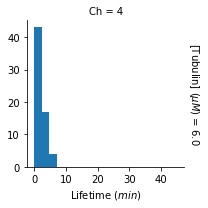

In [165]:
g = sns.FacetGrid(df, row=tubulin, col="Ch", margin_titles=True)
bins = np.linspace(0, 45, 20)
g.map(plt.hist, Lifetime, bins=bins)
plt.savefig(path/('Lifetime'+'_'+date+'.jpg'),bbox_inches='tight')

In [33]:
g = sns.FacetGrid(df, row=tubulin, col="DCX Type", margin_titles=True)
bins = np.linspace(0, 10, 20)
g.map(plt.hist, ShrinkageRate, bins=bins)

KeyError: 'DCX Type'